In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.lib import solve_2d_ode_spectral
from pywave.energy_transport.energy_transfer_2dirns import EnergyTransfer2Dirns

In [43]:
class ET2dirnsManager(EnergyTransfer2Dirns):
    def __init__(self, dx, dt, cg,
                 neumann=True,
                 u_in=1,
                 reflection_coefficient=1,
                 alpha=.1,
                 gamma=0,
                 nx=100,
                 nt=50,
                 outdir=None,
                 **kwargs):
        super().__init__(dx, dt, **kwargs)
        self.nx = nx
        self.nt = nt
        self.x = np.arange(nx, dtype=float)*dx
        self.u_in = u_in
        self.outdir = outdir
        self.set_init_cons()
        self.set_scattering_props(alpha, gamma, cg)
        self.set_steady_cons(alpha, gamma, reflection_coefficient)

    def set_init_cons(self):
        self.u0 = np.full_like(self.x, self.u_l)
        self.u0[self.x>self.x[self.nx//3]] = 0
        self.v0 = np.zeros_like(self.x)
        self.u = self.u0.copy()
        self.v = self.v0.copy()

    def set_scattering_props(self, alpha, gamma, cg):
        self.scattering_mask = np.zeros_like(self.x)
        self.scattering_mask[self.x>self.x[self.nx//2]] = 1.
        self.alpha = alpha*self.scattering_mask
        self.gamma = gamma*self.scattering_mask
        self.cg = np.full_like(self.x, cg)
         
    def set_steady_cons(self, alpha, gamma, reflection_coefficient):
        a, b, c, d = self.get_source_matrix(alpha, gamma, shape=(1,))
        dcg = np.gradient(self.cg)/self.dx
        abcd = [arr/self.cg[0] for arr in (a - dcg[0], b, -c, dcg[0] - d)]
        u0 = np.array([self.u_l])
        v0 = reflection_coefficient*u0
        self.u_steady = np.full_like(self.x, u0[0])
        self.v_steady = np.full_like(self.x, v0[0])
        wh = np.where(self.scattering_mask==1.)
        x = self.x[wh]
        self.u_steady[wh], self.v_steady[wh] = (
            arr.flatten() for arr in solve_2d_ode_spectral(u0, v0, x-x[0], *abcd))

    def plot_step(self, n):
        plt.close()
        fig, axes = plt.subplots(
            nrows=3, ncols=1, sharex=True, squeeze=True)
        for ax, arr, arr_steady, ylabel in zip(
                axes,
                [self.u, self.v, self.u + self.v],
                [self.u_steady, self.v_steady, self.u_steady + self.v_steady],
                ["$E_+$", "$E_-$", "E_+ + E_-"],
                ):
            ax.plot(self.x, arr_steady, 'r')
            ax.plot(self.x, arr, '--')
            ax.set_ylabel(ylabel)
            ax.set_yscale('log')
            ax.set_ylim([1e-4, 3])
            ttl = "t=%5.3f" %(n*self.dt)
        axes[0].set_title(ttl)
        axes[-1].set_xlabel("x, m")
        if self.outdir is None: return
        os.makedirs(self.outdir, exist_ok=True)
        figname = os.path.join(self.outdir, 'et2d_%3.3i.png' %n)
        plt.savefig(figname)
        
    def step_with_bcs(self):
        nghost = 3
        n = self.nx + 2*nghost
        s = slice(nghost, -nghost)
        def pad(vec, val, dtype=float):
            padded = np.full((n,), val)
            padded[s] = vec[:]
            return padded
        upad = pad(self.u, self.u_l)
#         print(self.u)
#         print(upad)
        vpad = pad(self.v, 0.)
        cgpad = pad(self.cg, self.cg[0])
        apad = pad(self.alpha, 0.)
        gpad = pad(self.gamma, 0.)
        upad, vpad = self.step(upad, vpad, cgpad, apad, gpad)
#         print(upad)
#         print(vpad[-15:])
        self.u = upad[s]
        self.v = vpad[s]

    def run(self, reps=10):
        if self.outdir is not None:
            print(f"Saving figs in {self.outdir}")
        for n in range(1, self.nt+1):
            self.step_with_bcs()
            if n%reps != 0: continue
            print(f"Plotting step {n} out of {self.nt}")
            self.plot_step(n)

In [37]:
cfl = .9
dx = 1
dt = 1
alpha = 5e-2
gamma = 0
cg = cfl*dx/dt
refl = 1

# Anisotropic scattering

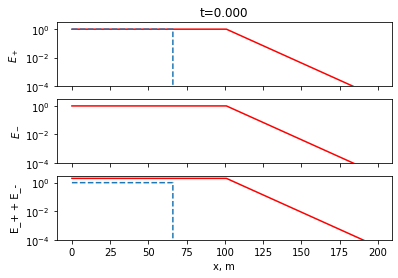

In [41]:
# no dissipation
# - implicit solver with smaller time step
et2d = ET2dirnsManager(
    dx, dt/10, cg, u_l=1,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma,
    nx=200,
    nt=1000,
    outdir="figs_aniso_implicit",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="implicit",
)
et2d.plot_step(0)

In [39]:
# check steady solution
print(
    et2d.u_steady[101:121], 
    np.exp((-2*alpha/cg)*np.arange(20)*dx),
    sep='\n'
)

[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]
[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]


Saving figs in figs_aniso_implicit
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

 0.   0.   0.   0.  ]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0

 0.   0.   0.   0.   0.   0.   0.   0.91 1.   1.  ]
[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0. 

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.09 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[1 1 1 1 1 1

 0.   0.   0.   0.  ]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0

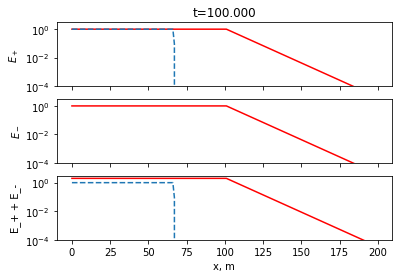

In [42]:
et2d.run(reps=50)

In [1]:
# no dissipation
# - split-step solver with larger time step
# - final results not very sensible
et2d = ET2dirnsManager(
    dx, dt, cg, u_l=1,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma,
    nx=200,
    nt=2000,
    outdir="figs_aniso_split",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="split_step",
)
et2d.plot_step(0)
et2d.run(reps=10)

NameError: name 'ET2dirnsManager' is not defined

In [8]:
"""
gamma = 0
uss = np.array([[-1,0],[0,0]])# simple model: u attenuated, no E transferred to v
et = EnergyTransfer2Dirns(dx, dt,
                            unit_scat_source=uss,
                            scheme='first_order_upwind',
                            u_correction_scheme="split_step",
                         )
run(et, u0, v0, c, alpha, gamma, x, outdir='et_fou', **kw_init)
"""

'\ngamma = 0\nuss = np.array([[-1,0],[0,0]])# simple model: u attenuated, no E transferred to v\net = EnergyTransfer2Dirns(dx, dt,\n                            unit_scat_source=uss,\n                            scheme=\'first_order_upwind\',\n                            u_correction_scheme="split_step",\n                         )\nrun(et, u0, v0, c, alpha, gamma, x, outdir=\'et_fou\', **kw_init)\n'